# Key Summary

### Mar 31: train dictionary on another file


### Mar 8 & 11: visualize topic trends



### Mar 1 & 6: parse the rest of transcripts
- POS of "NNP" plus "\r\n" parsed pretty well
- Identify the paragraph breakers
- next: parse


### Feb 23 & 24 & 25: proof of concent
- cleanse the code
- calculate the weight of each word in each topic
- visualization on topics across events

### Feb 17 & 19: impliment POS
- using POS seems to be an easier solution to rmove people's name and titles
- <font color='red'>topcis make more sense now</font>
- Next: remain country names
- idea: use (word, pos) to run topic modeling? 

### Feb 15: topic modeling on paragraphs 2019
- **Try paragraph-based topic modeling and <font color='red'>you can see the topcis are different now</font>**
- cleanse the code

### Feb 12: topic modeling on tf-idf files 2015-2019
- Tried tf-idf on all files, didn't work

### Feb 9: topic modeling on wordcount vector files 2015-2019
As discussed on Feb 3, the input of dynamic topic modeling are files, so I postponed parsing transcripts into paragraphs.

- I downloaded all transcripts from 2015-2019 
- First topic modeling result

### Feb 1: parsing files
- Parse fancy files
- the basic unit: each paragraph spoken by one person (i.e. the content divided by dotted line)
- clean those words that are repeated and obviously useless
- Words appeared in the front page and CORPORATE PARTICIPANTS session are repeated and contain no information


### Jan 27 
- I tried different package to read pdf, and pdftotext works best for the transcripts files
- There are two format types. One is fancier. 
- My next step is to parse the fancier files.


### Reference
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- NLTK POS tag list: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

# Topic modeling on transcripts from 2015 to 2019

## Parsing

In [1]:
import pandas as pd
import os
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
%%time
# set years
years = list(range(2010,2020))

# get file names, file paths, type
files = consolidate_files(years)

# parse into paragraphs
df = filenames_to_para(files)

Wall time: 1min 8s


## Preprocessing

In [6]:
%%time
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

Wall time: 59.6 s


In [7]:
# removing some words
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning", 
    "company", "mean", "wraptext", "”", '’'
]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

## filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
df = df[df["len_clean"]>10]

# removing disclaimer
df = df[df["paragraph"].map(lambda x: "The information in the transcripts" not in x)]
df = df[df["paragraph"].map(lambda x: "disclaimer" not in x.lower())]

In [30]:
# removing some paragraphs
removing_words = ["www.streetevents.com"]

mask = df["tokens_clean"].map(lambda x: removing_words[0] not in x)
df = df[mask]

# removing short paragraphs
df = df[df.len_clean > 22]

## Check omni's tag

In [84]:
# df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)
# tokens_pos = df["tokens_pos"]
# key_word = "omni"
# check = get_unique_words(tokens_pos)
# check = pd.DataFrame(check)
# check["pos"] = check.index
# check[check["pos"].map(lambda x: key_word in x[0])]

,0,pos
"(omni-channel, JJ)",10,"(omni-channel, JJ)"
"(omnichannel, NN)",10,"(omnichannel, NN)"
"(omnichannel, JJ)",4,"(omnichannel, JJ)"
"(omni-channel, NN)",3,"(omni-channel, NN)"
"(omni, JJ)",2,"(omni, JJ)"
"(omni-offering, NN)",1,"(omni-offering, NN)"
"(omni, RP)",1,"(omni, RP)"
"(omni-retail, NN)",1,"(omni-retail, NN)"
"(omni, NNS)",1,"(omni, NNS)"
"(omni-retail, JJ)",1,"(omni-retail, JJ)"


In [12]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

## LDA

In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [46]:
# prepare count vector as the input of LDA model
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 20

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
number_words = 12
# print_topics(lda, count_vectorizer, number_words)

words = count_vectorizer.get_feature_names()

# print topics and key words
for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic + 1, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 1  ====================
market          3.12%
continue        3.01%
sale            1.98%
price           1.95%
productivity      1.85%
growth          1.67%
leverage        1.64%
improve         1.37%
comp            1.32%
number          1.18%
topic: 2  ====================
sale            6.35%
percent         4.91%
increase        2.70%
continue        2.01%
basis           1.96%
grow            1.93%
growth          1.92%
member          1.87%
comp            1.71%
income          1.67%
topic: 3  ====================
comp            2.85%
sale            2.58%
continue        2.35%
price           1.52%
category        1.46%
percent         1.31%
drive           1.24%
point           1.06%
deliver         1.02%
assortment      0.98%
topic: 4  ====================
call            3.22%
today           3.08%
result          2.79%
president       2.50%
website         1.62%
earnings        1.55%
comp            1.49%
release         1.39%
report          1.37%
guidance        

In [20]:
# import gensim
# dictionary = gensim.corpora.Dictionary(df["tokens_clean"])
# dictionary.filter_extremes(no_below=1, no_above=0.5)
# bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_clean"]]
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
#                                        passes=2, workers=2, chunksize=100, random_state=1000)

In [25]:
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(lda_model.print_topics())

[   (   0,
        '0.032*"sort" + 0.027*"today" + 0.024*"website" + 0.022*"statement" + '
        '0.021*"presentation" + 0.018*"release" + 0.017*"earnings" + '
        '0.016*"call" + 0.016*"follow-up" + 0.016*"use"'),
    (   1,
        '0.019*"team" + 0.017*"market" + 0.014*"growth" + 0.013*"continue" + '
        '0.012*"world" + 0.012*"opportunity" + 0.010*"people" + 0.010*"come" + '
        '0.010*"focus" + 0.009*"part"'),
    (   2,
        '0.030*"delivery" + 0.026*"ecommerce" + 0.017*"technology" + '
        '0.015*"couple" + 0.014*"people" + 0.014*"fulfillment" + 0.014*"asset" '
        '+ 0.013*"need" + 0.013*"day" + 0.012*"build"'),
    (   3,
        '0.041*"member" + 0.028*"category" + 0.024*"comp" + 0.022*"club" + '
        '0.017*"membership" + 0.016*"continue" + 0.014*"drive" + 0.013*"point" '
        '+ 0.011*"increase" + 0.011*"sale"'),
    (   4,
        '0.033*"change" + 0.024*"people" + 0.023*"term" + 0.021*"brand" + '
        '0.019*"give" + 0.018*"price" + 0.018

## Visualize topic distribution

In [32]:
# assign topic to paragraphs
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

# # chech how many topics in each paragraphs
# df["number of topics"] = [sum(x>x.mean()) for x in topic_match]

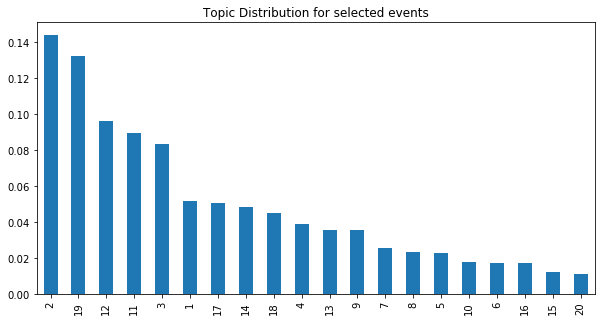

In [33]:
topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

## Visualize paragraph counts for each year

In [34]:
# df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
df['year'] = pd.PeriodIndex(df.date, freq='Y')

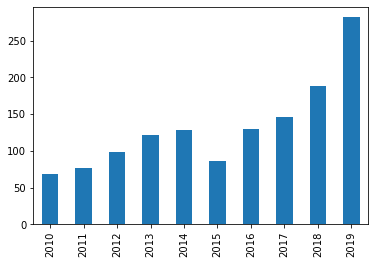

In [35]:
df["year"].value_counts().sort_index().plot(kind='bar')

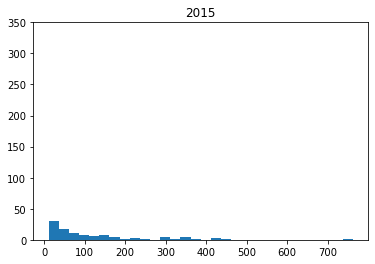

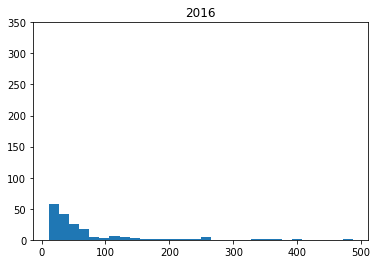

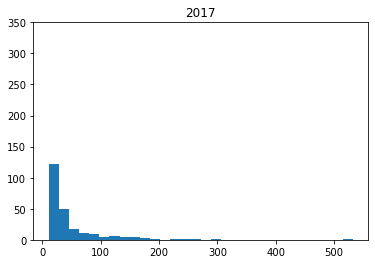

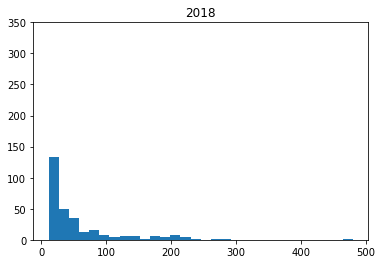

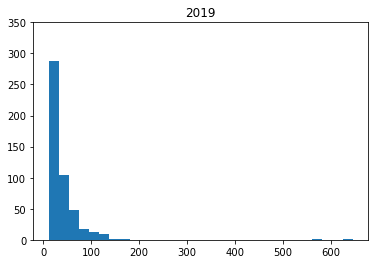

In [113]:
# # visualize the distribution of paragraph length 
# for year in range(2015, 2020):
#     check = df[df.year == year]
#     fig, ax = plt.subplots()
#     plt.hist(check.len_clean, bins=30)
#     plt.ylim(0, 350)
#     # plt.xticks(years, years, rotation='vertical')
#     plt.title(str(year))

In [36]:
df.groupby(by=["year"])["len_clean"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,69.0,167.695652,124.413838,26.0,70.00,132.0,213.00,493.0
2011,77.0,167.506494,138.298935,23.0,63.00,116.0,254.00,581.0
2012,99.0,143.444444,110.277037,24.0,62.50,109.0,201.00,502.0
2013,122.0,146.959016,157.456508,23.0,37.00,86.5,194.75,811.0
2014,128.0,128.742188,135.705868,23.0,38.75,76.5,153.00,718.0
2015,86.0,147.988372,135.462910,23.0,46.25,96.5,202.75,762.0
2016,130.0,83.784615,84.124860,23.0,33.00,54.0,96.75,487.0
2017,146.0,68.636986,65.786161,23.0,30.00,42.0,86.50,532.0
2018,188.0,80.329787,68.026951,23.0,31.75,53.0,102.50,480.0


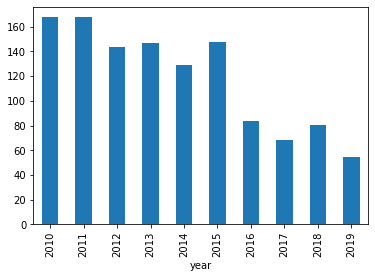

In [112]:
df.groupby(by=["year"])["len_clean"].describe()["mean"].plot(kind='bar')

In [37]:
test = df[df.len_clean > 22].copy()

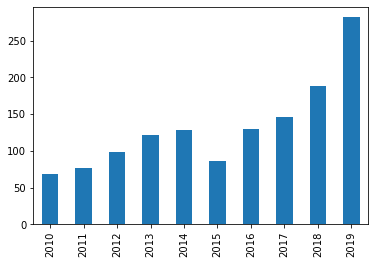

In [38]:
test["year"].value_counts().sort_index().plot(kind='bar')

## Topic trends

In [39]:
tmp = pd.crosstab(test["year"], test["topic"], normalize="index")
years = [ str(x) for x in tmp.index]

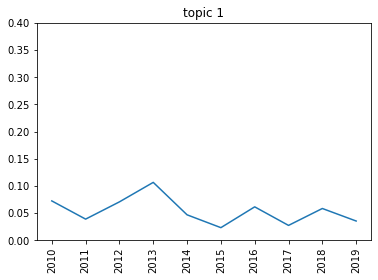

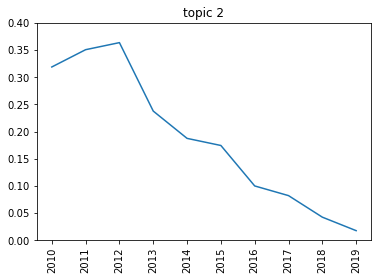

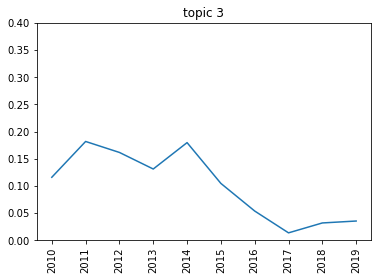

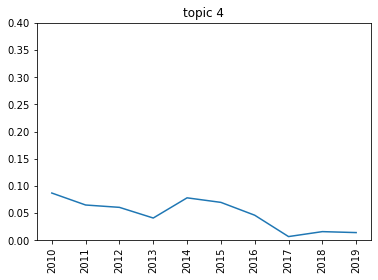

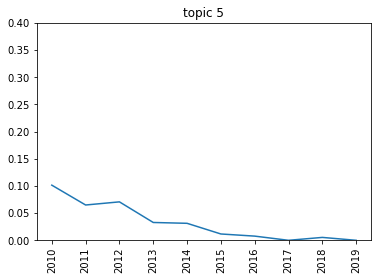

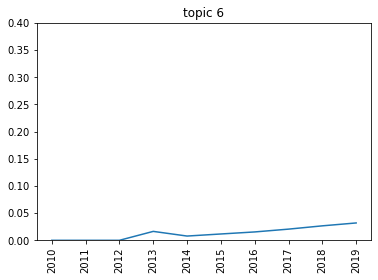

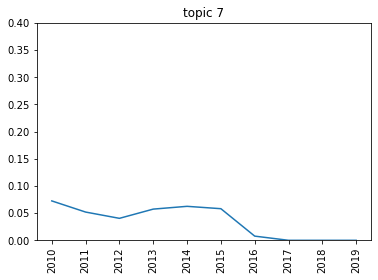

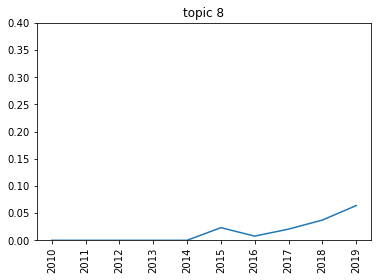

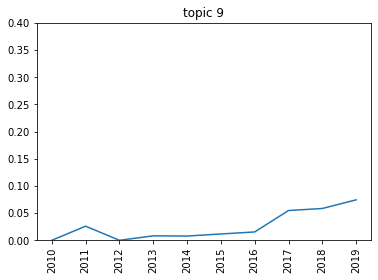

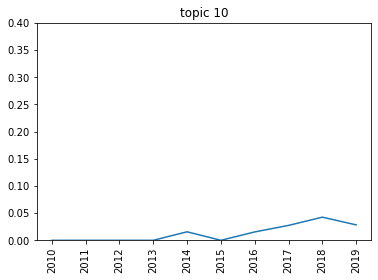

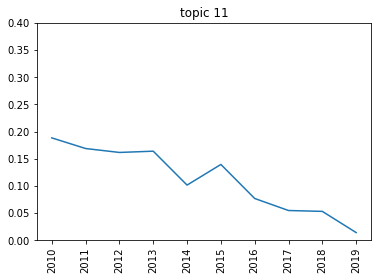

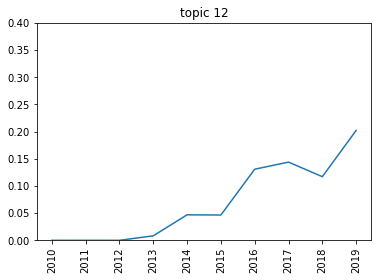

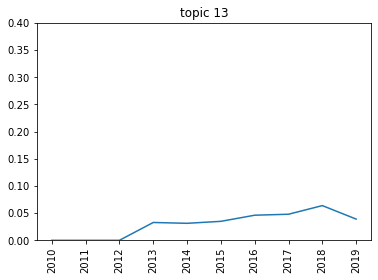

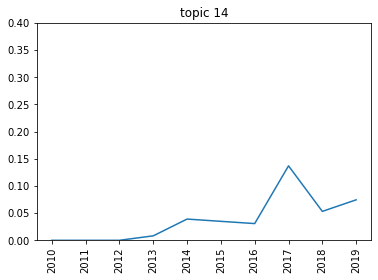

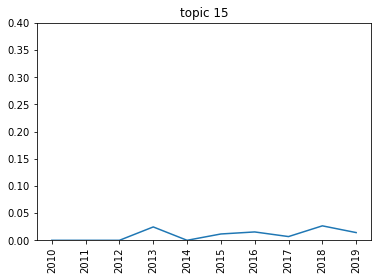

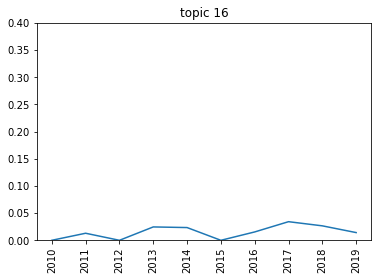

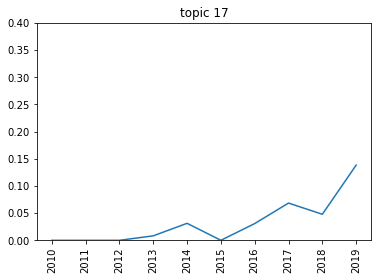

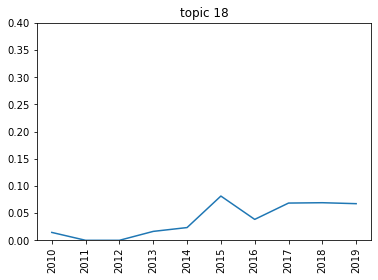

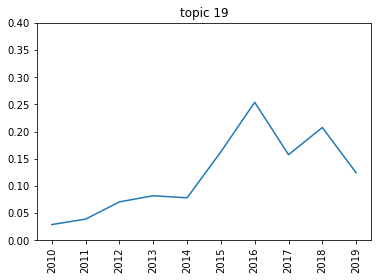

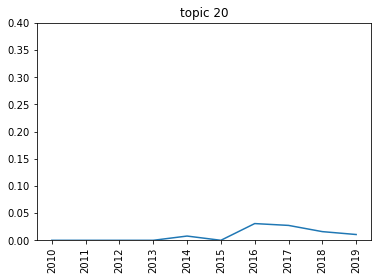

In [42]:
for topic in tmp:
    fig, ax = plt.subplots()
    plt.plot(years, tmp[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

In [111]:
check = test[test["topic"]==18]
check[check["year"] == 2017]["paragraph"].iloc[0]

'WRAPTEXT Brett Biggs - Wal-Mart Stores , Inc. - EVP and CFO WRAPTEXT Yes , so we built five brand-new fulfillment centers over the last say 18 months , 2 years . Those now are really what has helped enable the 2-day WRAPTEXT shipping . I mean , we will continue to address the logistics network . It will be interesting over time . Today the ECHIS network is a bit different from WRAPTEXT sending pallets to a store . So having those dedicated fulfillment centers is what we need to have today . WRAPTEXT I think over time it will be interesting to see how or if those start to merge . Whether that is backwards in the supply chain or whether that is how WRAPTEXT we get them to the stores , it is the things that our logistics group are thinking about all of the time , is how those -- eventually , will they come WRAPTEXT together , how will they come together ? Will they stay separate ? If so , how do you stay efficient ? So that is the calculus that they are always going WRAPTEXT through .'

In [107]:
check[check["paragraph"].map(lambda x: "associate" in x)]

,paragraph,date,tokens,tokens_pos,tokens_clean,len_clean,corpus,topic,year
61,WRAPTEXT Thanks Brian . Before I get into our ...,2010-05-18,"[WRAPTEXT, Thanks, Brian, ., Before, I, get, i...","[(get, VBP), (report, NN), (card, NN), (report...","[report, card, report, growth, leverage, retur...",57,"report, card, report, growth, leverage, return...",18,2010
829,WRAPTEXT Bill Simon : With respect to the pres...,2014-02-20,"[WRAPTEXT, Bill, Simon, :, With, respect, to, ...","[(respect, NN), (press, NN), (came, VBD), (yes...","[respect, press, come, yesterday, news, positi...",48,"respect, press, come, yesterday, news, positio...",18,2014
997,WRAPTEXT Bill Simon : Minimum wage is a debate...,2014-05-15,"[WRAPTEXT, Bill, Simon, :, Minimum, wage, is, ...","[(wage, NN), (is, VBZ), (debate, NN), (needs, ...","[wage, debate, need, hold, country, considerat...",34,"wage, debate, need, hold, country, considerati...",18,2014
1242,"WRAPTEXT Thanks Carol , and good morning every...",2015-02-19,"[WRAPTEXT, Thanks, Carol, ,, and, good, mornin...","[(morning, NN), (everyone, NN), (had, VBD), (q...","[everyone, close, earnings, share, deliver, ex...",138,"everyone, close, earnings, share, deliver, exp...",18,2015
1249,WRAPTEXT Walmart U.S.15E-C3CC3F52A027 WRAPTEXT...,2015-02-19,"[WRAPTEXT, Walmart, U.S.15E-C3CC3F52A027, WRAP...","[(joined, VBD), (team, NN), (months, NNS), (la...","[join, team, month, lay, objective, half, need...",225,"join, team, month, lay, objective, half, need,...",18,2015
1251,WRAPTEXT Walmart Grocery online to select loca...,2015-02-19,"[WRAPTEXT, Walmart, Grocery, online, to, selec...","[(online, NN), (select, VB), (locations, NNS),...","[online, select, location, market, advantage, ...",134,"online, select, location, market, advantage, d...",18,2015
1281,WRAPTEXT CB4FCFC8-6667-41AC-8A6E-922E4E63B06C ...,2015-05-19,"[WRAPTEXT, CB4FCFC8-6667-41AC-8A6E-922E4E63B06...","[(provided, VBD), (update, NN), (business, NN)...","[provide, update, discuss, need, improvement, ...",71,"provide, update, discuss, need, improvement, o...",18,2015
1394,"WRAPTEXT Greg Foran - Wal-Mart Stores , Inc. -...",2015-10-14,"[WRAPTEXT, Greg, Foran, -, Wal-Mart, Stores, ,...","[(does, VBZ), (sort, NN), (feeds, NNS), (point...","[sort, feed, point, term, people, pay, bonus, ...",63,"sort, feed, point, term, people, pay, bonus, a...",18,2015
1465,"WRAPTEXT Doug McMillon - Wal-Mart Stores , Inc...",2015-10-14,"[WRAPTEXT, Doug, McMillon, -, Wal-Mart, Stores...","[(starts, VBZ), (look, VB), (ladder, NN), (cas...","[start, ladder, case, people, join, opportunit...",41,"start, ladder, case, people, join, opportunity...",18,2015
1749,"WRAPTEXT Doug McMillon - Wal-Mart Stores , Inc...",2016-06-03,"[WRAPTEXT, Doug, McMillon, -, Wal-Mart, Stores...","[(know, VBP), (investments, NNS), ('ve, VBP), ...","[investment, put, pressure, expense, couple, a...",35,"investment, put, pressure, expense, couple, an...",18,2016


## Interactive visualization

In [47]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 1min 29s


In [48]:
pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.100057  0.192032       1        1  23.383209
2     -0.045460  0.166093       2        1  13.204003
10    -0.218680  0.154227       3        1  12.807908
18     0.077418  0.100524       4        1  11.244913
11     0.145641  0.005894       5        1   4.827792
4     -0.219663  0.055430       6        1   4.665226
0     -0.008368  0.137290       7        1   4.605162
17     0.122649 -0.003298       8        1   3.894074
3     -0.205351 -0.128034       9        1   3.230539
13     0.144118 -0.000917      10        1   3.102106
16     0.169414 -0.059912      11        1   3.067816
6     -0.271579 -0.065873      12        1   2.405063
12    -0.020626  0.055399      13        1   2.168527
8      0.143466 -0.020551      14        1   1.703079
7      0.135491 -0.059833      15        1   1.474073
9      0.116541 -0.031298      16        1   0.993423
19    -0.212203 -0.300605      17        1   0.874736
14     0.079800 -0.060513      18        1   0.812477
15     0.089316 -0.071913      19        1   0.802696
5      0.078133 -0.064143      20        1   0.733178, topic_info=     Category         Freq          Term        Total  loglift  logprob
2731  Default  2852.000000       percent  2852.000000  30.0000  30.0000
2052  Default   557.000000     inventory   557.000000  29.0000  29.0000
3681  Default   484.000000     statement   484.000000  28.0000  28.0000
2311  Default  1295.000000        market  1295.000000  27.0000  27.0000
3423  Default   623.000000       segment   623.000000  26.0000  26.0000
2891  Default  1201.000000         price  1201.000000  25.0000  25.0000
855   Default  2049.000000      continue  2049.000000  24.0000  24.0000
450   Default   516.000000         brand   516.000000  23.0000  23.0000
527   Default   556.000000          call   556.000000  22.0000  22.0000
1242  Default   414.000000      earnings   414.000000  21.0000  21.0000
739   Default  1385.000000          comp  1385.000000  20.0000  20.0000
3353  Default  3699.000000          sale  3699.000000  19.0000  19.0000
951   Default   673.000000      currency   673.000000  18.0000  18.0000
1575  Default   739.000000         focus   739.000000  17.0000  17.0000
255   Default   586.000000     associate   586.000000  16.0000  16.0000
3462  Default   914.000000         share   914.000000  15.0000  15.0000
2057  Default   917.000000    investment   917.000000  14.0000  14.0000
3273  Default  1170.000000        result  1170.000000  13.0000  13.0000
1438  Default   657.000000        expect   657.000000  12.0000  12.0000
3887  Default   364.000000          term   364.000000  11.0000  11.0000
1952  Default  1665.000000      increase  1665.000000  10.0000  10.0000
3858  Default   728.000000          team   728.000000   9.0000   9.0000
1948  Default   974.000000        income   974.000000   8.0000   8.0000
3852  Default   420.000000           tax   420.000000   7.0000   7.0000
2307  Default   435.000000        margin   435.000000   6.0000   6.0000
1744  Default   497.000000       grocery   497.000000   5.0000   5.0000
3031  Default   863.000000          rate   863.000000   4.0000   4.0000
1759  Default   422.000000      guidance   422.000000   3.0000   3.0000
3953  Default   499.000000         today   499.000000   2.0000   2.0000
1944  Default   506.000000       include   506.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1454  Topic20     2.632296       explain    10.334053   3.5479  -5.9498
3600  Topic20    13.611583     something   154.272183   2.4877  -4.3068
3784  Topic20    11.253075      supplier   131.167603   2.4597  -4.4970
2593  Topic20     3.347883  optimization    17.900911   3.2390  -5.7094
3327  Topic20     7.104360          room    77.243713   2.5293  -4.9570
3982  Topic20     5.532987         trade    56.127773   2.5986  -5.2070
2583  Topic20     8.127432       

## Visualize components for each year (stop using for now)

IndexError: list index out of range

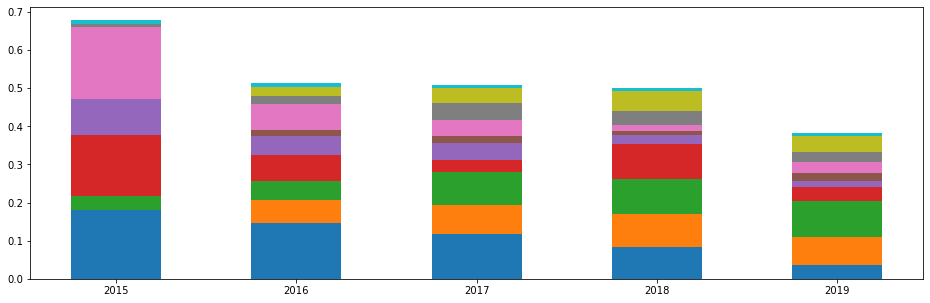

In [144]:
event_tp = df.groupby(by=["year","topic"])["topic"].count().unstack().fillna(0)
tmp = event_tp.T.apply(sum)
event_tp = event_tp.apply(lambda x: x/tmp)
event_tp.index = [str(x)[:10] for x in event_tp.index]

fig, ax = plt.subplots(figsize=(16, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
bottom = np.array([0]*event_tp.shape[0])
x = event_tp.index.values

for i in event_tp.columns:
#     print(event_tp[i].values)
    plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
    bottom = bottom + event_tp[i]

plt.legend(event_tp.columns)
plt.title("Topic distribution across events")

## Below is work before POS

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data) # the input of TfidfTransformer is a matrix of term/token counts
tf_idf_vector = tfidf_transformer.transform(count_data)

number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)
print_topics(lda, count_vectorizer, number_words)


Topic #0:
barclays karen short capital thank operator proceed line please next

Topic #1:
pile money development house audience 24 replicate degree either india

Topic #2:
sure pleasure true reasonable super specifically fair card india confusing

Topic #3:
michael lasser securities okay balance thanks dastugue quickly idea mean

Topic #4:
stephens bienvenu richard international mayfield paul trussell deutsche thank bank

Topic #5:
officer walmart gregory foran solid carefully flag remember lost anything

Topic #6:
merchandising back great steve bratspies private part category first opportunity

Topic #7:
bank lynch ohmes merrill america robert sorry guy india scott

Topic #8:
information advertising herein provided including 00 bienvenu stephens correct report

Topic #9:
director douglas mcmillon learning decision holiday might current skus assuming


In [8]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)      
print_topics(lda, count_vectorizer, number_words)


Topic #0:
information capital short barclays karen including provided herein report without

Topic #1:
pickup delivery basket merchandise seeing term shop serve assortment service

Topic #2:
bank securities paul trussell deutsche guy pretty term sure skus

Topic #3:
technology thank feel pretty sure statement place thanks trying 00

Topic #4:
private label long guy five money even inside probably channel

Topic #5:
private category label world model delivery number space versus important

Topic #6:
stephens bienvenu 00 quarter mean next line first please okay

Topic #7:
sale comp quarter margin product number leverage take billion expense

Topic #8:
commerce 00 feel place always world data program profitability done

Topic #9:
item delivery help million sure 00 feel doug center first


### Previous work

In [4]:
import pdftotext
import os
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline  

def get_text(filepath):
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    return(text)

In [2]:
%%time

path = os.getcwd() + '\data\Transcripts'
years = os.listdir(path)

# get all filenames and the text in the files
files = pd.DataFrame()
for year in years:
    filenames = os.listdir(path + "\\" + year)
    filepaths = [path + "\\" + year + "\\" + filename for filename in filenames]
    texts = [get_text(path) for path in filepaths]
    tmp = pd.DataFrame([filenames, texts]).T
    files = pd.concat([files, tmp], ignore_index=True)

files.columns = ["filename", "text"]

Wall time: 4.4 s


In [3]:
%%time
files["tokens"] = files["text"].map(nltk.word_tokenize)
files["tokens_count"] = files["tokens"].map(len)

Wall time: 9.01 s


#### Decide what words to be deleted

In [4]:
from itertools import chain
all_tokens = list(chain.from_iterable(files["tokens"]))
all_tokens = pd.Series(all_tokens)
tokens_count = all_tokens.value_counts()
len(tokens_count)

11937

In [5]:
%%time
unique_tokens = pd.DataFrame()
unique_tokens["token"] = tokens_count.index
unique_tokens["counts"] = tokens_count.values

punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
unique_tokens["punctuation"] = unique_tokens["token"].map(lambda x: x in punctuation)

stop_words = set(stopwords.words('english'))
unique_tokens["stop_words"] = unique_tokens["token"].map(lambda x: x.lower() in stop_words)

unique_tokens["only_twice"] = unique_tokens["counts"].map(lambda x: x <= 2)

unique_tokens["len"] = unique_tokens["token"].map(len)
unique_tokens["too_short"] = unique_tokens["len"] <= 2 # this might eliminate US and UK
unique_tokens["too_long"] = unique_tokens["len"] >= 16 

unique_tokens["apostrophe_comma"] = unique_tokens["token"].map(lambda x: '\'' in x or ',' in x)

removing = (unique_tokens["punctuation"] == True) | (unique_tokens["stop_words"] == True) \
| (unique_tokens["only_twice"] == True) | (unique_tokens["too_short"] == True) \
| (unique_tokens["too_long"] == True) | (unique_tokens["apostrophe_comma"] == True)

remain_token = unique_tokens[~removing]

# remain_token[remain_token["token"].map(lambda x: x[0].isupper())]

removing_words = unique_tokens[removing]["token"]

Wall time: 70.4 ms


In [20]:
len(remain_token)

5586

#### Visualize remaining words

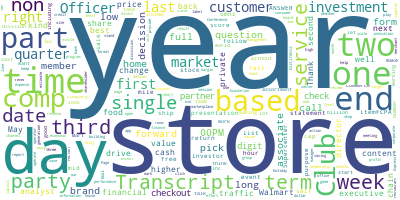

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(remain_token['token'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Preparing data for LDA

In [35]:
%%time
## need to optimize here
files["cleansed_tokens"] = files["tokens"].map(lambda x: [word for word in x if word in remain_token["token"].values])

Wall time: 2min 50s


In [41]:
files["cleansed_tokens"][0]

['WAL-MART',
 'STORES',
 'INC.',
 'NYSE',
 'WMT',
 'Fourth',
 'Quarter',
 'Fiscal',
 'Year',
 '2015',
 'Earnings',
 'Call',
 'February',
 '2015',
 'Management',
 'call',
 'recorded',
 'Carol',
 'Schumacher',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Global',
 'Investor',
 'Relations',
 'Hello',
 'Carol',
 'Schumacher',
 'vice',
 'president',
 'global',
 'investor',
 'relations',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Thanks',
 'joining',
 'today',
 'date',
 'call',
 'February',
 '2015',
 'call',
 'property',
 'Wal-Mart',
 'Stores',
 'Inc.',
 'intended',
 'use',
 'Walmart',
 'shareholders',
 'investment',
 'community',
 'reproduced',
 'way',
 'listening',
 'phone',
 'may',
 'navigate',
 'call',
 'follows',
 'Press',
 'key',
 'rewind',
 'playback',
 'seconds',
 'Press',
 'key',
 'pause',
 'resume',
 'playback',
 'Press',
 'key',
 'fast-forward',
 'playback',
 'seconds',
 'call',
 'contain',
 'statements',
 'Walmart',
 'believes',
 'forward-',
 'looking',
 'statements',
 'within',
 'meaning',
 'Privat

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA

files["corpe"] = files["cleansed_tokens"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(files["corpe"])

number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
walmart year sales quarter percent comp growth customers business stores

Topic #1:
reuters thomson stores inc wal mart going year customers walmart

Topic #2:
reuters thomson stores inc walmart think going wal mart really

Topic #3:
walmart inc think chief officer executive president vice financial factset

Topic #4:
year really think walmart business current going one company customers


## 12th Feb
- use tfidf instead of count vector

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data)
tf_idf_vector = tfidf_transformer.transform(count_data)

In [38]:
tf_idf_vector.shape

(48, 4758)

In [39]:
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #1:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #2:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #3:
percent sales walmart quarter year comp growth increased results fiscal

Topic #4:
reuters walmart thomson think inc stores business going really year
